In [1]:
""" Introduction
Moving Average Convergence Divergence (MACD) is a trend indicator

It is usually calculated based on a 12-period Exponential Moving Average (EMA) and a
16-period EMA being:
    MACD = EMA(12) - EMA(26)
The MACD is comparede against an EMA(9) that is called as signal-line

When the MACD line crosses above from above the Signal-Line then we can consider
it as a bying signal, otherwise it will be considered as a selling signal

It allows to identificate periods in which the market is gaining some momentum


This script aims to create a smooth visualisation of the MACD indicator

"""

' Introduction\nMoving Average Convergence Divergence (MACD) is a trend indicator\n\nIt is usually calculated based on a 12-period Exponential Moving Average (EMA) and a\n16-period EMA being:\n    MACD = EMA(12) - EMA(26)\nThe MACD is comparede against an EMA(9) that is called as signal-line\n\nWhen the MACD line crosses above from above the Signal-Line then we can consider\nit as a bying signal, otherwise it will be considered as a selling signal\n\nIt allows to identificate periods in which the market is gaining some momentum\n\n\nThis script aims to create a smooth visualisation of the MACD indicator\n\n'

In [2]:
# The old friends
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.axes

# The finance friends
import pandas_ta as ta
import yfinance as yf

# Time manipulation
import datetime

# Colors manipulation
from colour import Color

In [3]:
""" 1. Create a function for data subsetting """
def subset_df (tickers, start_date, end_date):   
    df = pd.DataFrame()

    # 1.1. Populate the data frame
    df = df.ta.ticker(tickers)
    df["Date"] = df.index

    # 1.2. Add the column date for subsetting
    df_subsetted = df[(df["Date"] >= start_date) & (df["Date"] <= end_date)]
    price_df = pd.DataFrame(df_subsetted["Close"])
    
    macd_df = df_subsetted.ta.macd(fast = 12, slow = 26, signal = 9)
    macd_df = macd_df.rename(columns = {"MACD_12_26_9": "MACD Line", 
                                        "MACDh_12_26_9": "MACD Difference Line",
                                        "MACDs_12_26_9": "MACD Signal Line"})

    macd_df['position'] = macd_df['MACD Line'] > macd_df['MACD Signal Line'] # indicating a buying signal
    macd_df['pre_position'] = macd_df['position'].shift(1)
    macd_df['Cross_Over'] = np.where(macd_df['position'] == macd_df['pre_position'], False, True)
    
    macd_df = macd_df.drop(columns = [macd_df.columns[3], macd_df.columns[4]], axis = 1)

        
    macd_df["Cross_Signal"] = ""
    for row in range(0, len(macd_df)):
        if np.isnan(macd_df.iloc[row,0]) == True:
            macd_df.iloc[row,4] = 0
        elif np.isnan(macd_df.iloc[row,0]) == False & np.isnan(macd_df.iloc[row-1,0]) == True:
            macd_df.iloc[row,4] = 0
        else:
            if (macd_df.iloc[row,3] == True) & (macd_df.iloc[row,0] > macd_df.iloc[row,2]):
                macd_df.iloc[row,4] = 1
            elif (macd_df.iloc[row,3] == True) & (macd_df.iloc[row,0] < macd_df.iloc[row,2]):
                macd_df.iloc[row,4] = -1
            else:
                macd_df.iloc[row,4] = 0
    
    macd_df = macd_df.drop(columns = [macd_df.columns[3]], axis = 1)

    
    return (macd_df,price_df)

""" 2. Create function to define the x tick marks frequency on the plot """
def x_interval (data_frame, range_parameter = "M"):
    """ run this function with df from subset_df and range parameter (d,m,y)
    """
    x = data_frame.index.to_numpy(dtype = object)
    x_axis = []
    month = 0 # There is no month 0, therefore the first value is always placed
    
    for date in range(0, len(x)):
        if range_parameter == "M":
            if date == 0:  
                prior_month = x[date].to_pydatetime().month
            else:
                month = x[date].to_pydatetime().month
        elif range_parameter == "D":
            if date == 0:  
                prior_month = x[date].to_pydatetime().day
            else:
                month = x[date].to_pydatetime().day
        elif range_parameter == "Y":
            if date == 0:  
                prior_month = x[date].to_pydatetime().year
            else:
                month = x[date].to_pydatetime().year

        if month != prior_month:
            x_axis.append(x[date])
            prior_month = month
        elif date == 0:
            x_axis.append(x[date])
        elif date == len(x):
            x_axis.append(x[date])
        else:
            pass
        
    return x_axis

""" 3. Create a function to define the ticks in which there is a positive/negative
crossover"""
def red_green_crossing(df):
    """ df input is the output of subset_df """
    df = df[0]
    
    green_list = []
    red_list = []
    
    for row in range(0, len(df)):
        if df.iloc[row,2] == 1:
            green_list.append(df.index[row])
        elif df.iloc[row,2] == -1:
            red_list.append(df.index[row])
        else:
            pass
    return (green_list, red_list)

In [4]:
""" 4. Obtain the data """ 
    # 4.1. Define data variables
start_date = "2021-05-01"
end_date = "2021-12-03" 
tickers = "TSLA"
    # 4.2. Get the Data Frame 
asset_data = subset_df(tickers, start_date, end_date)
    # 4.3. Get the data for x interval ticks
x_axis = x_interval(asset_data[0], range_parameter = "M")
    # 4.4. Get the data for crossing points
vertical_markers = red_green_crossing(asset_data)
green_list = vertical_markers[0]
red_list = vertical_markers[1]

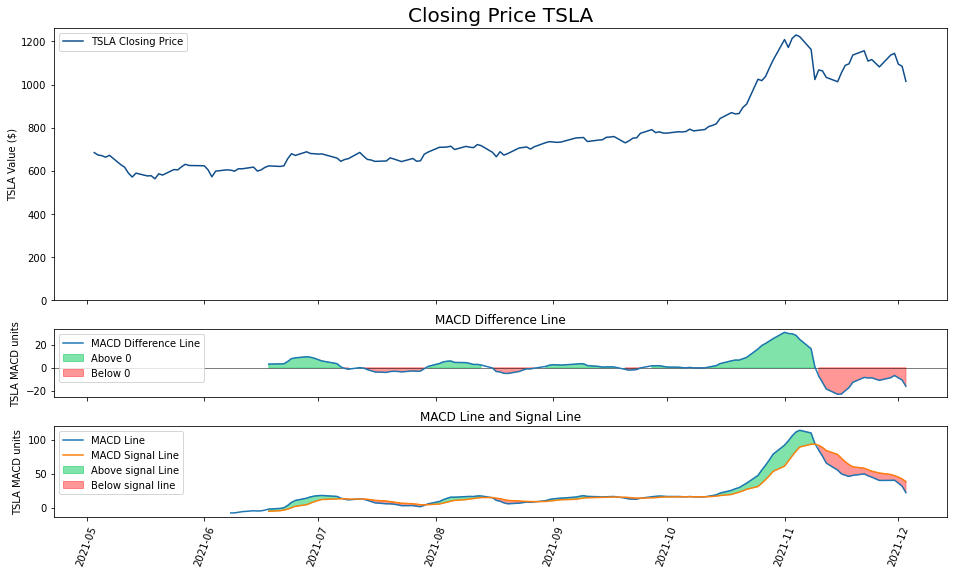

In [5]:
""" 5. Plot the data """ 
fig, (ax1, ax2, ax3) = plt.subplots(3,1, sharex = True, gridspec_kw={'height_ratios': [6, 1.5, 2]})

    # 5.1. Plot Price Data
ax1.plot(asset_data[1]["Close"], label = tickers + " Closing Price", color = "#104E8B", )
ax1.set_title("Closing Price " + tickers,  fontsize = 20)
ax1.set_ylim(0,ax1.axis()[3])
ax1.set_ylabel(tickers + " Value ($)")
ax1.legend()

    # 5.2.Plot MACD Data
macd_data = asset_data[0][["MACD Line","MACD Signal Line"]]
ax3.plot(macd_data, label = ["MACD Line", "MACD Signal Line"])
ax3.set_ylim(ax3.axis()[2],ax3.axis()[3])

ax3.set_title("MACD Line and Signal Line")
plt.xticks(ticks = x_axis, rotation = 70)
fig.set_size_inches(16, 9, forward=True)

    # 5.2.1. Fill the space between lines
ax3.fill_between(macd_data.index, macd_data["MACD Line"], macd_data["MACD Signal Line"],
                 where = (np.array(macd_data["MACD Line"]) > np.array(macd_data["MACD Signal Line"])),
                 color = "#00C957", alpha = 0.5, label = "Above signal Line")
ax3.fill_between(macd_data.index, macd_data["MACD Line"], macd_data["MACD Signal Line"],
                 where = (np.array(macd_data["MACD Line"]) < np.array(macd_data["MACD Signal Line"])),
                 color = "#FF3030", alpha = 0.5, label = "Below signal line")
    # 5.2.2. Adjust x size for visibility
ax3.set_xlim(ax1.axis()[0],ax1.axis()[1])
ax3.set_ylabel(tickers + " MACD units")

ax3.legend()

    # 5.3. Plot the MACD Difference Line
macd_diffline_data = asset_data[0][["MACD Difference Line"]]
ax2.plot(macd_diffline_data, label = "MACD Difference Line")
ax2.set_ylim(ax2.axis()[2],ax2.axis()[3])
ax2.set_title("MACD Difference Line")

    
    # 5.3.1. Fill the space between lines
ax2.fill_between(macd_diffline_data.index, 0, macd_diffline_data["MACD Difference Line"],
                 where = (np.array(macd_diffline_data["MACD Difference Line"])>0),
                 color = "#00C957", alpha = 0.5, label = "Above 0")
ax2.fill_between(macd_diffline_data.index, 0, macd_diffline_data["MACD Difference Line"],
                 where = (np.array(macd_diffline_data["MACD Difference Line"])<0),
                 color = "#FF3030", alpha = 0.5, label = "Below 0")
ax2.hlines(0, ax2.axis()[0], ax2.axis()[1], linewidth = 0.5, color = "black")
ax2.set_ylabel(tickers + " MACD units")            
ax2.legend()


# Plot the vertical lines
maximo = ax1.axis()[3]
maximo_1= ax3.axis()[3]
minimo_1 = ax3.axis()[2]
for xc in green_list:
    ax1.vlines(xc, 0, maximo, color = "green", linewidth = 0.5)
    ax3.vlines(xc, minimo_1, maximo_1, color = "green", linewidth = 0.5)

for xc in red_list:
    ax1.vlines(xc, 0, maximo, color = "red", linewidth = 0.5)
    ax3.vlines(xc, minimo_1, maximo_1, color = "red", linewidth = 0.5)
    

plt.show()